# Advanced Lane Line Detection

TODO: short description of project here

In [182]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

%matplotlib inline

### 1. Camera calibration

In [113]:
def calibrate_camera(imgs, nx=9, ny=6):
    # Collect object points and image points for use in calibrating camera
    obj_pts = [] # 3D points in the real world space
    img_pts = [] # 2D points in the image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ... , (8,5,0)
    obj_pt = np.zeros((ny * nx, 3), np.float32)
    # z-coordinate will stay zero; but x, y coordinates need to be generated
    obj_pt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in imgs:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add object points and image points
        if found:
            print('found corners in {}'.format(fname))
            img_pts.append(corners)
            obj_pts.append(obj_pt)

            img = cv2.drawChessboardCorners(img, (nx,ny), corners, found)
            plt.imshow(img)
            
    return obj_pts, img_pts
        
        

found corners in ./camera_cal/calibration15.jpg
found corners in ./camera_cal/calibration20.jpg
found corners in ./camera_cal/calibration17.jpg
found corners in ./camera_cal/calibration3.jpg
found corners in ./camera_cal/calibration13.jpg
found corners in ./camera_cal/calibration6.jpg
found corners in ./camera_cal/calibration19.jpg
found corners in ./camera_cal/calibration18.jpg
found corners in ./camera_cal/calibration14.jpg
found corners in ./camera_cal/calibration12.jpg
found corners in ./camera_cal/calibration2.jpg
found corners in ./camera_cal/calibration10.jpg
found corners in ./camera_cal/calibration7.jpg
found corners in ./camera_cal/calibration9.jpg
found corners in ./camera_cal/calibration8.jpg
found corners in ./camera_cal/calibration16.jpg
found corners in ./camera_cal/calibration11.jpg
17 17


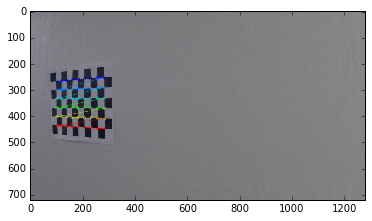

In [114]:
imgs = glob.glob('./camera_cal/calibration*.jpg')
object_points, image_points = calibrate_camera(imgs)
print(len(object_points), len(image_points))

### 2. Distortion correction

In [115]:
def correct_distortion(image, object_points, image_points):
    '''
    Calibrates camera and corrects for camera distortions in the provided image
    based on the provided object points mapped to the provided image points.
    Returns the corrected, undistorted image.
    '''
    ret, cam_mtx, dist_coeffs, rot_vecs, trans_vecs = \
        cv2.calibrateCamera(object_points, image_points, image.shape[1::-1], None, None)
        
    return cv2.undistort(image, cam_mtx, dist_coeffs, None, None)

In [116]:
def display_images(images, titles, cmaps=[]):
    '''
    Displays two images side by side.
    
    arguments:
    images -- a list of two images to display. (anything in the list beyond the first two will be ignored)
    cmaps  -- a list of color maps for the destination image
    titles -- a list of titles to match the provided images
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title(titles[0], fontsize=30)
    if cmaps and cmaps[0]:
        ax1.imshow(images[0], cmap=cmaps[0])
    else:
        ax1.imshow(images[0])
                          
    ax2.set_title(titles[1], fontsize=30)
    if cmaps and cmaps[1]:
        ax2.imshow(images[1], cmap=cmaps[1])
    else:
        ax2.imshow(images[1])
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

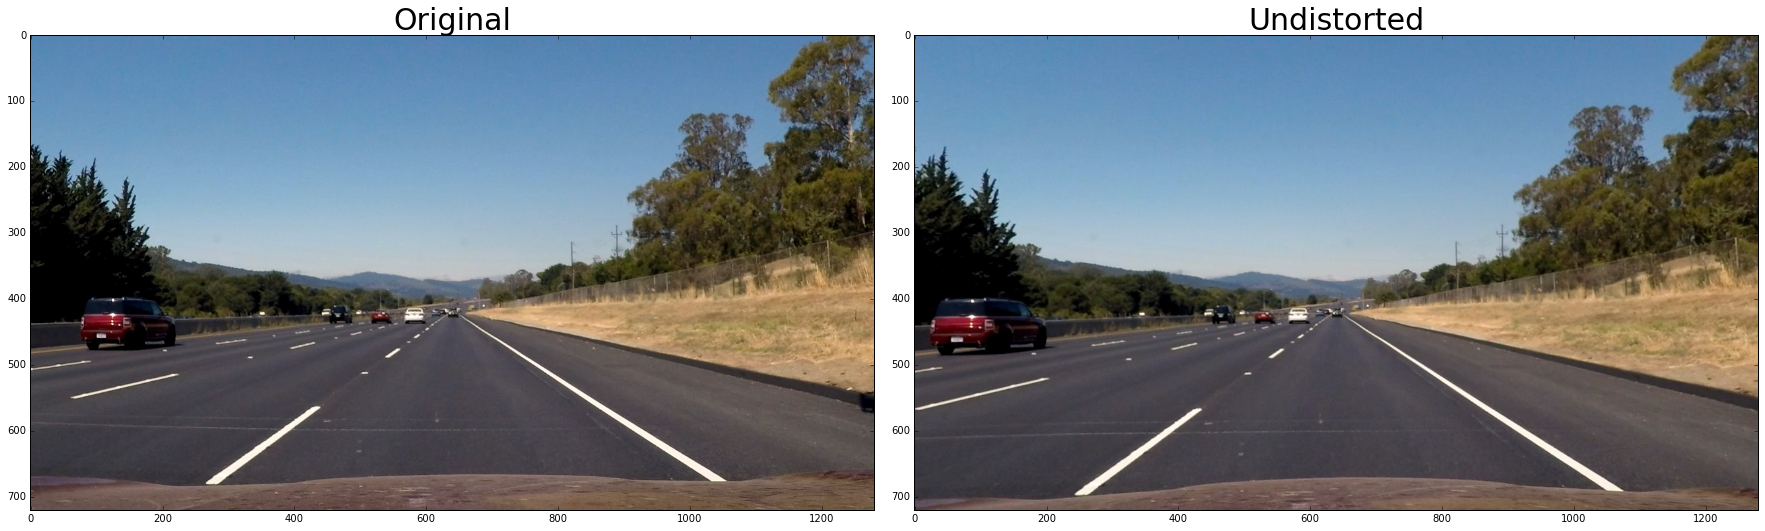

In [349]:
test_img = mpimg.imread('./test_images/straight_lines2.jpg')
#test_img = mpimg.imread('./test_images/test2.jpg')
corrected = correct_distortion(test_img, object_points, image_points)
display_images([test_img, corrected], ['Original', 'Undistorted'])

### 3. Color/gradient threshold

In [118]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculate the directional gradient and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8((255 * abs_sobel) / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary


In [119]:
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    '''Calculate the gradient magnitude and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8((255 * mag_sobelxy) / np.max(mag_sobelxy))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary


In [237]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient direction and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobelx = np.sqrt(np.square(sobelx))
    mag_sobely = np.sqrt(np.square(sobely))
    grad_dir = np.arctan2(mag_sobely, mag_sobelx)
    #scaled = np.uint8((255 * grad_dir) / np.max(grad_dir))
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary


In [121]:
def hls_threshold(image, channel='h', thresh=(90, 255)):
    '''Calculate the color threshold for the requested channel
    and apply the threshold
    
    arguments:
    image -- a color image in RGB format
    channel -- the requested channel to use for applying the threshold values
    thresh -- min and max (inclusive) values for the range of the threshold to apply
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    layer = H
    if channel == 'l' or channel == 'L':
        layer = L
    elif channel == 's' or channel == 'S':
        layer = S
        
    hls_binary = np.zeros_like(layer)
    hls_binary[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return hls_binary


In [345]:
def combine_thresholds(image, sobel_kernel_size=5, 
                       grad_x_thresh=(20, 100),
                       grad_y_thresh=(20, 100),
                       magnitude_thresh=(50, 75),
                       grad_dir_thresh=(0.65, 1.35),
                       s_chan_thresh=(200, 255),
                       h_chan_thresh=(70, 150),
                       l_chan_thresh=(150, 255)):
    '''
    Combines gradient and color thresholds applied to the provided image
    to maximize identification of lane lines
    '''
    # TODO: tune default threshold ranges
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # just for visual reference
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel_size, thresh=grad_x_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel_size, thresh=grad_y_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=magnitude_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=grad_dir_thresh)
    s_chan_binary = hls_threshold(image, channel='s', thresh=s_chan_thresh)
    h_chan_binary = hls_threshold(image, channel='h', thresh=h_chan_thresh)
    l_chan_binary = hls_threshold(image, channel='l', thresh=l_chan_thresh)
    
    # Combine the applied thresholds 
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | \
             ((mag_binary == 1) & (dir_binary == 1)) | \
             (((s_chan_binary == 1) & (h_chan_binary == 0)) | (l_chan_binary == 1))] = 1
        
    return combined, gray, gradx, grady, mag_binary, dir_binary, s_chan_binary, h_chan_binary, l_chan_binary


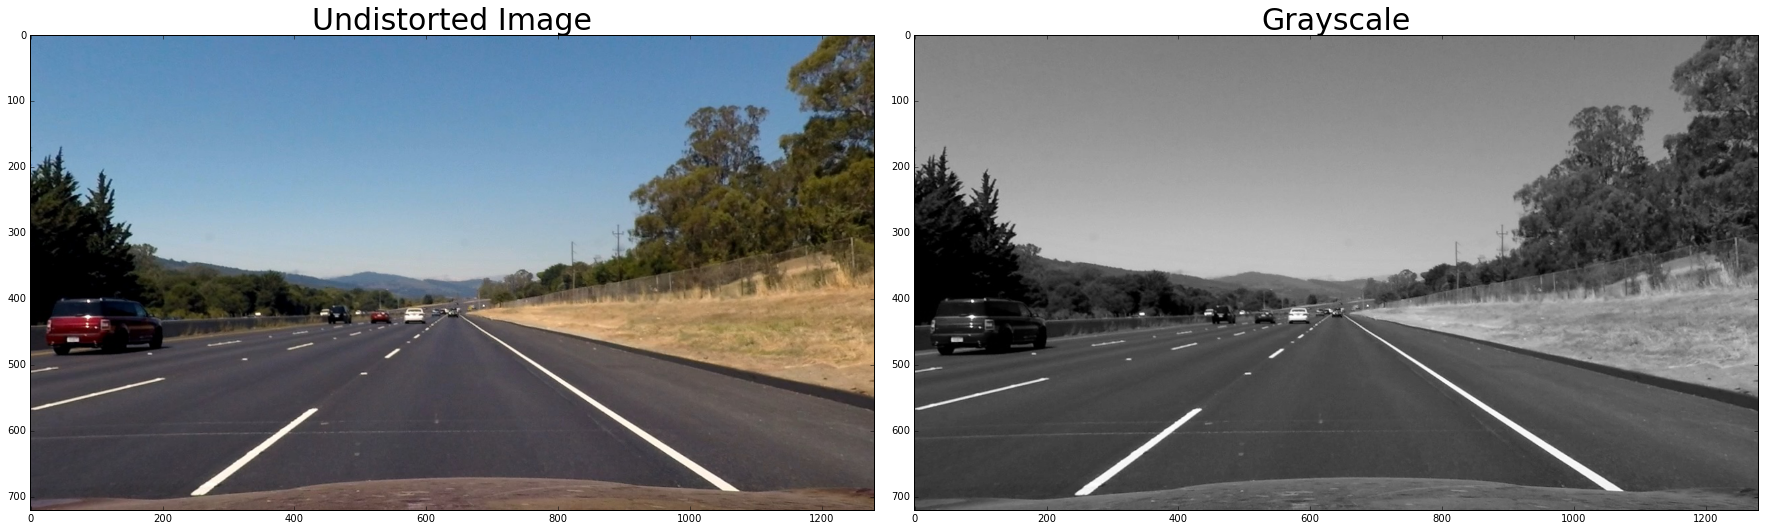

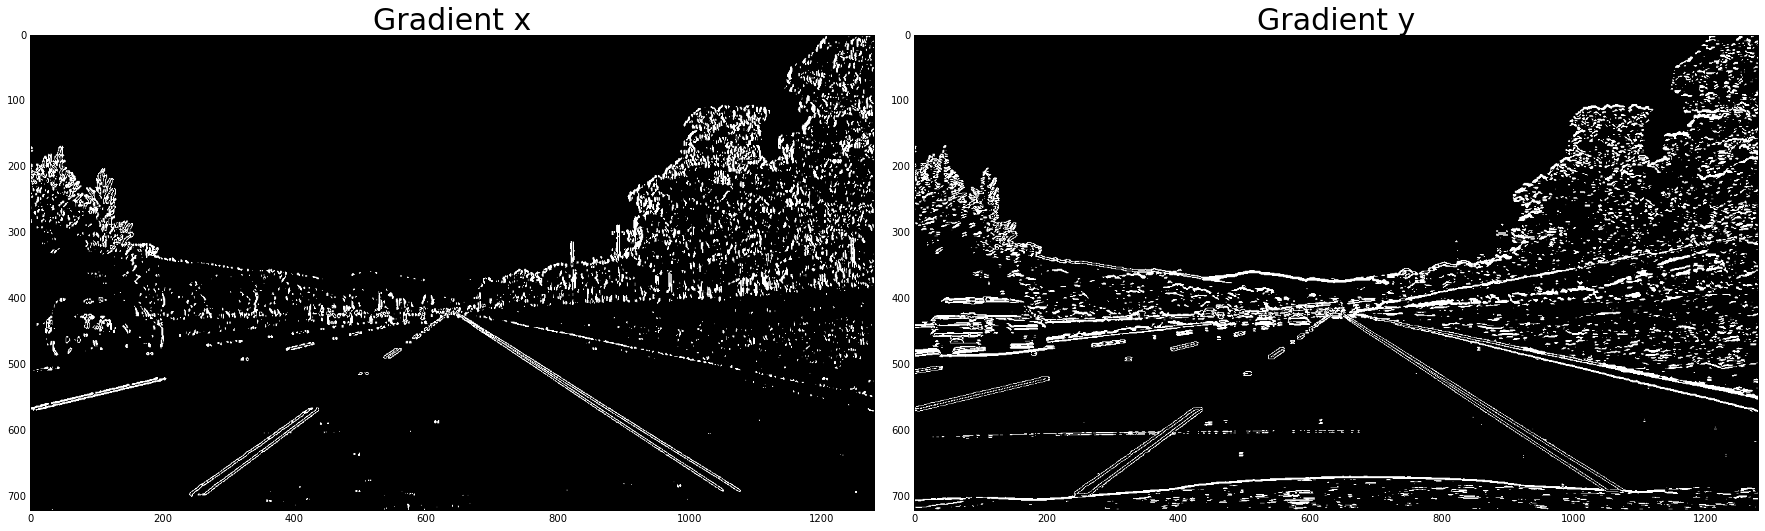

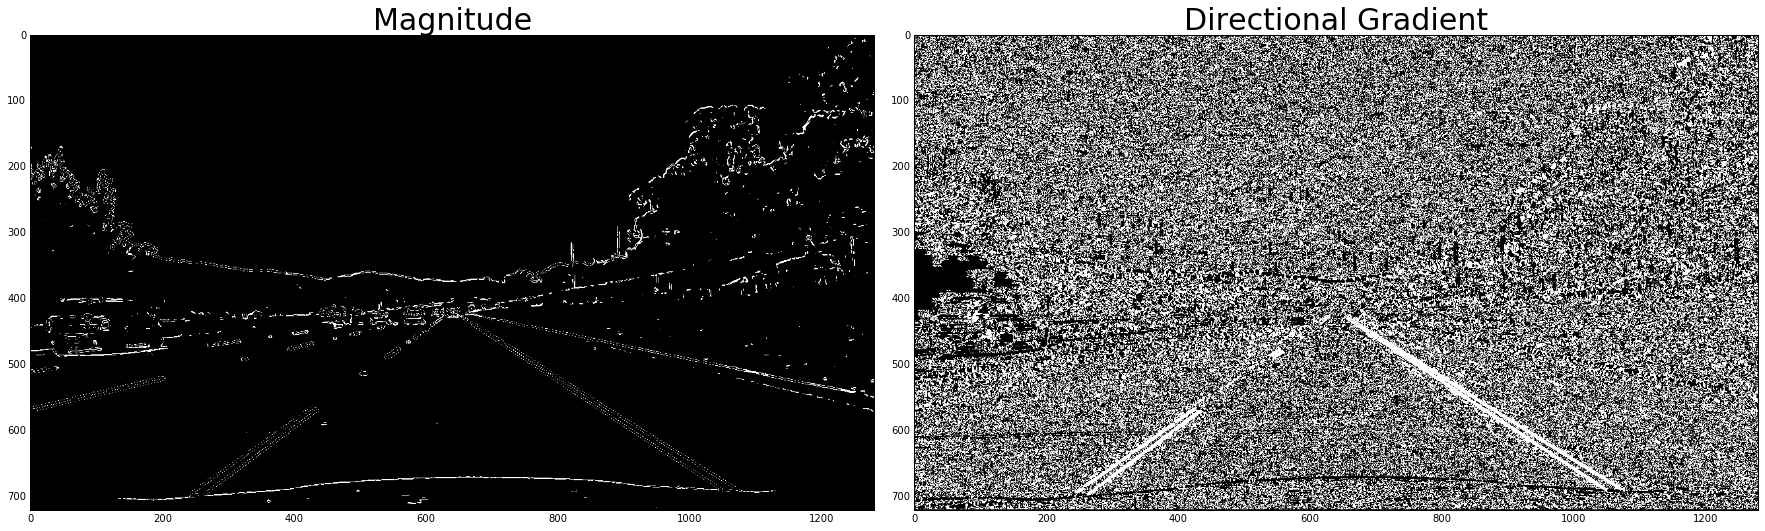

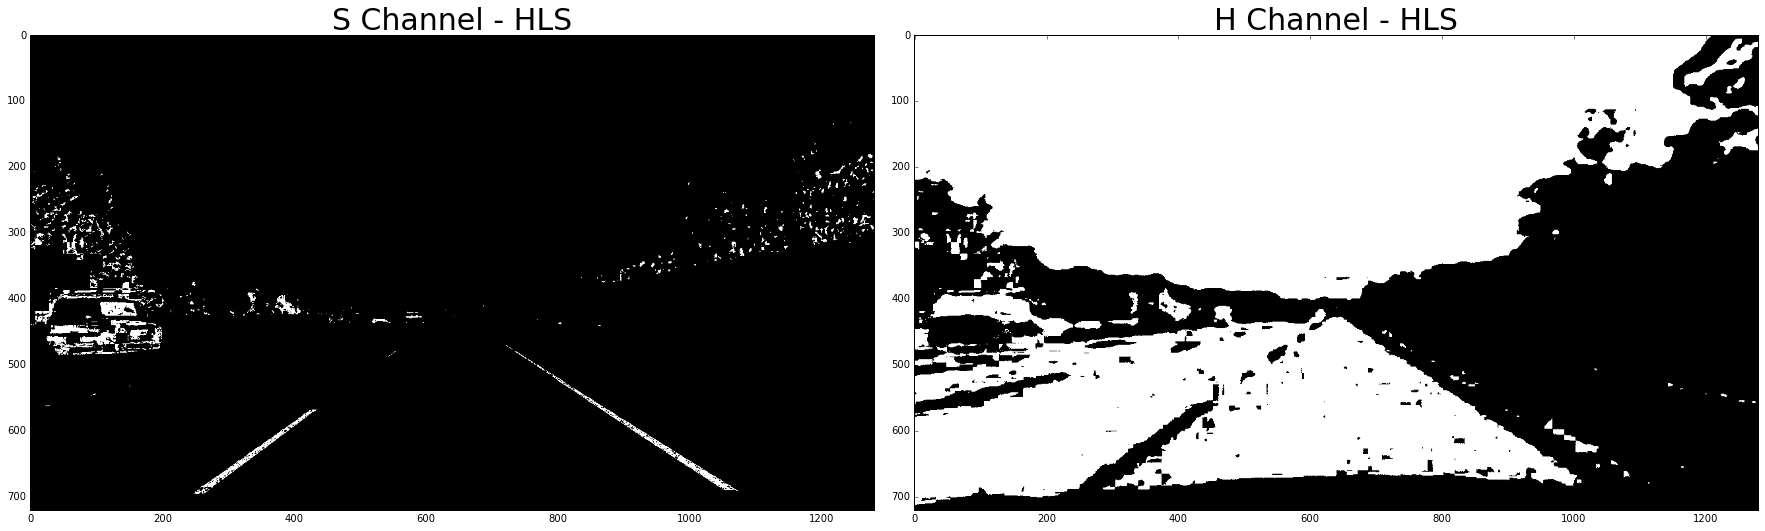

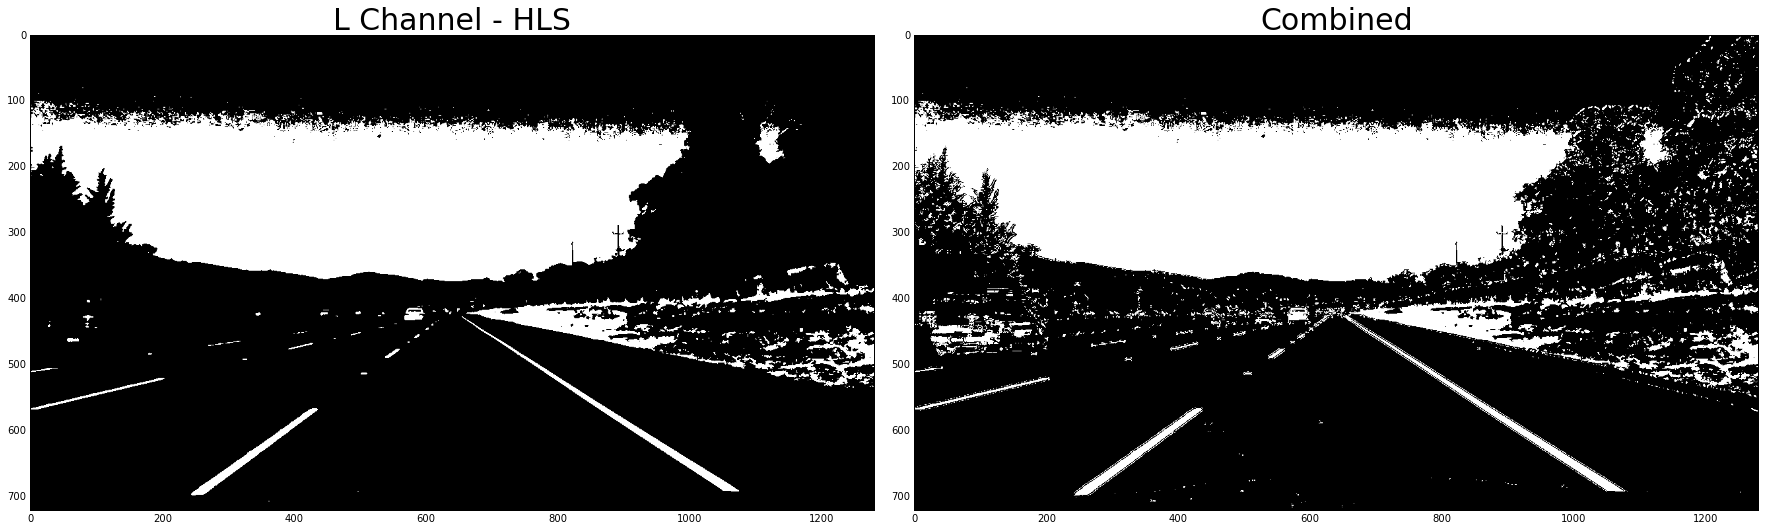

In [350]:
# Test combined threshold
combined_grad_color, gray, gradx, grady, mag_binary, \
dir_binary, s_chan_binary, h_chan_binary, l_chan_binary = \
    combine_thresholds(corrected)
    
display_images([corrected, gray], ['Undistorted Image', 'Grayscale'], ['', 'gray'])
display_images([gradx, grady], ['Gradient x', 'Gradient y'], ['gray', 'gray'])
display_images([mag_binary, dir_binary], ['Magnitude', 'Directional Gradient'], ['gray', 'gray'])
display_images([s_chan_binary, h_chan_binary], ['S Channel - HLS', 'H Channel - HLS'], ['gray', 'gray'])
display_images([l_chan_binary, combined_grad_color], ['L Channel - HLS', 'Combined'], ['gray', 'gray'])

### 4. Perspective transform

In [268]:
def warp_img(image, src, dst):
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, perspective_M, img_size, flags=cv2.INTER_LINEAR)
    return warped, perspective_M


In [316]:
def draw_polygon(image, vertices, color= 'r'):
    fig, ax = plt.subplots(1)
    area_of_interest = patches.Polygon(vertices, fill=False, edgecolor=color)
    ax.imshow(image, cmap='gray')
    ax.add_patch(area_of_interest)
    plt.show()
    

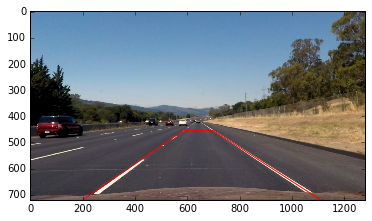

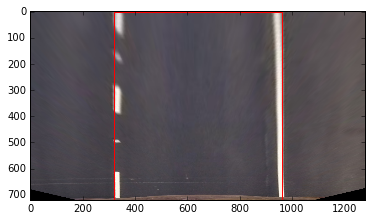

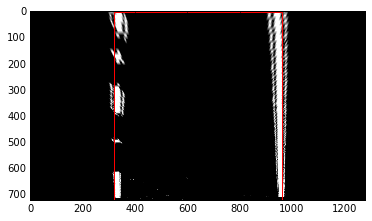

In [351]:
# Source image vertices for area of interest
stlx =  585
strx =  700
st_y =  455
sblx =  200
sbrx = 1110
sb_y =  720

src = np.float32([[strx, st_y],[sbrx, sb_y],
                  [sblx, sb_y],[stlx, st_y]])

# Destination image vertices for transformed area of interest
dtlx =  320
dtrx =  960
dt_y =    0
dblx = dtlx
dbrx = dtrx
db_y =  720

dst = np.float32([[dtrx, dt_y],[dbrx, db_y],
                  [dblx, db_y],[dtlx, dt_y]])

# Do perspective transformation to get a "Bird's eye view"
warped_test, p_M = warp_img(corrected, src, dst)
warped_combined, persp_M = warp_img(combined_grad_color, src, dst)

draw_polygon(corrected, src)
draw_polygon(warped_test, dst)

### 5. Detect lane lines

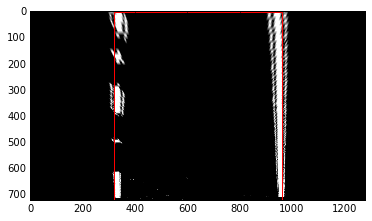

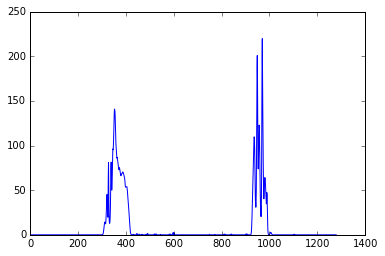

In [353]:
draw_polygon(warped_combined, dst)

# Show pixel density for lane lines in lower half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### 6. Determine the lane curvature